In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

This is my first official post on my personal website. The content is inspired by one of the assignments provided by Dr Brian Jackel at the University of Calgary: Physics and Astronomy http://contacts.ucalgary.ca/info/phas/profiles/486-146343

# In depth investigation of Atmospheric Carbon Dioxide Data.

This notebook makes a prediction of the CO2 level in distant future (year <2200) and assess the threat level we face. The data is available to the public at https://datahub.io/core/co2-ppm.

## Understanding the Data - Summary

Printing the first 10 rows of data

In [2]:
data=pd.read_csv("co2-mm-mlo_csv.csv",sep=',')
data[:10]

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
0,1958-03-01,1958.208,315.71,315.71,314.62,-1
1,1958-04-01,1958.292,317.45,317.45,315.29,-1
2,1958-05-01,1958.375,317.50,317.50,314.71,-1
3,1958-06-01,1958.458,-99.99,317.10,314.85,-1
4,1958-07-01,1958.542,315.86,315.86,314.98,-1
5,1958-08-01,1958.625,314.93,314.93,315.94,-1
6,1958-09-01,1958.708,313.20,313.20,315.91,-1
7,1958-10-01,1958.792,-99.99,312.66,315.61,-1
8,1958-11-01,1958.875,313.33,313.33,315.31,-1
9,1958-12-01,1958.958,314.67,314.67,315.61,-1


Decimal Date= Date decimal form  
Average= Monthly average of the CO2 ppm (has a value of -99.99 for missing data)  
Interpolated= Interpolated Monthly average of the CO2 ppm  
Trend= Trend of the Monthly Average of the CO2 ppm  

In [3]:
# Since the data is small, set up variables for easy access without performance loss.
Date_long=data['Date']
Date=data['Decimal Date']
Interpolated=data['Interpolated']
Trend=data['Trend']
Average=data['Average']

## Plot visualizations



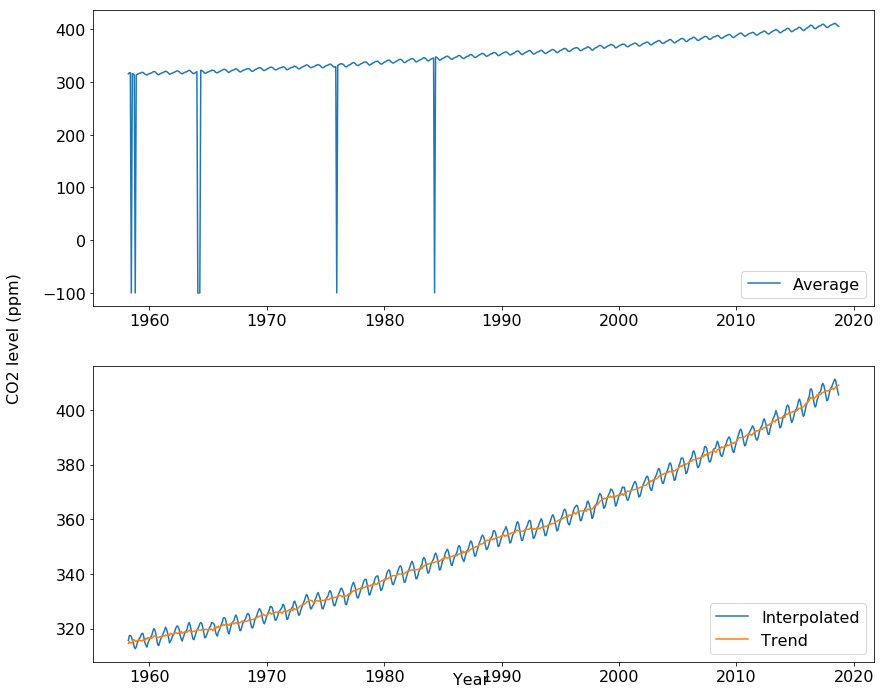

In [4]:
plt.rcParams.update({'font.size': 16})
fig,ax=plt.subplots(2,figsize=[14,12])

ax[0].plot(data["Decimal Date"], data['Average'], label='Average')
ax[1].plot(data['Decimal Date'], data['Interpolated'],label='Interpolated')
ax[1].plot(data['Decimal Date'], data['Trend'],label='Trend')
ax[0].legend(loc=4)
ax[1].legend(loc=4)
fig.text(0.04,0.5,"CO2 level (ppm)", rotation=90, verticalalignment='center')
fig.text(0.5,0.1,"Year", horizontalalignment='center')
plt.show()

## Pre-processing -  Assessment

Here i assess the need for pre-processing.

### Skewness

skewness statistic is defined as:

skewness$=\frac{\sum(x_i-\bar{x})^3}{(n-1)\nu^{2/3}}$ where $, \nu=\frac{\sum (x_i-\bar{x})^{2}}{n-1}$ [from Chapter 3 of Applied Predictive Modeling by Max Kuhn, Kjell Johnson]  


In [5]:
def find_skewness(x,nu):
    assert x.shape
    mean=np.mean(x)
    skewness=np.sum((x-mean)**3)
    return skewness/((x.size-1)*nu**(3/2))
    
def find_nu(x):
    mean=np.mean(x)
    nu=np.sum((x-mean)**2)
    return nu/(x.size-1)

nu=find_nu(Interpolated)
skewness=find_skewness(Interpolated,nu)

print("skewnewss: ",round(skewness,3))

skewnewss:  0.336


### General Statistics

In [6]:
data.describe()

,Decimal Date,Average,Interpolated,Trend,Number of Days
count,727.000000,727.000000,727.000000,727.000000,727.000000
mean,1988.458333,349.555846,353.640702,353.633054,18.341128
std,17.500926,52.068588,27.443136,27.369003,12.242015
min,1958.208000,-99.990000,312.660000,314.620000,-1.000000
25%,1973.333500,328.425000,328.555000,329.295000,-1.000000
50%,1988.458000,351.310000,351.310000,351.370000,24.000000
75%,2003.583500,375.700000,375.700000,376.135000,28.000000
max,2018.708000,411.240000,411.240000,409.020000,31.000000


I see no desperate need of a pre-processing since the values are finite with relatively low standard deviations, low skewness, and the data has already been pre-processed to a good degree from the source

## Decomposition

Based on visualization, it is clear that the Interpolated values can be divided into two componenets: Seasonal component and the Trend.

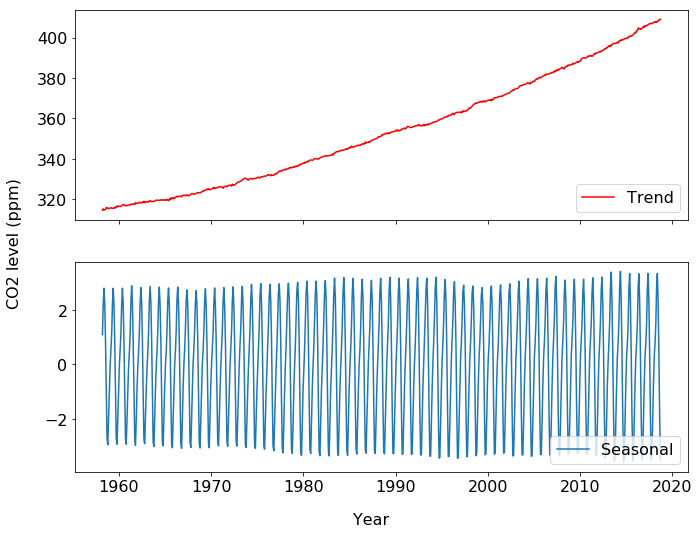

In [7]:
fig,ax=plt.subplots(2, figsize=[11,8.5],sharex=True)

ax[1].plot(Date, Interpolated-Trend, color='C0', label='Seasonal')
ax[0].plot(Date, Trend, color='red', label='Trend')
fig.text(0.04,0.5,"CO2 level (ppm)", rotation=90, verticalalignment='center')
fig.text(0.5,0.04,"Year", horizontalalignment='center')
for i in [0,1]:
    ax[i].legend(loc=4)

# Analysis
I perform two analysis, one for the Trend component and one for the Seasonal
### Analysis: Trend

The Trend data directly provides insights into the CO2's progression and behavior. We can answer common questions like:
1. In which year did it hit 400 ppm average?  
2. Average increase in ppm per year?

#### In which year did it hit 400 ppm?

In [8]:
first_400_ppm=Trend[Trend>400]
print("400 ppm was reached in the year: ",int(Date[first_400_ppm.index.values[0]]))

400 ppm was reached in the year:  2015


#### Average increase in ppm per year?

The growth is accelerating. One way to resolve this is to divide the plot into multiple segments, then apply linear regression to each segments. Let's divide it per 10 years.

Text(0.5,1,'Increase in CO2 concentration in the atmosphere')

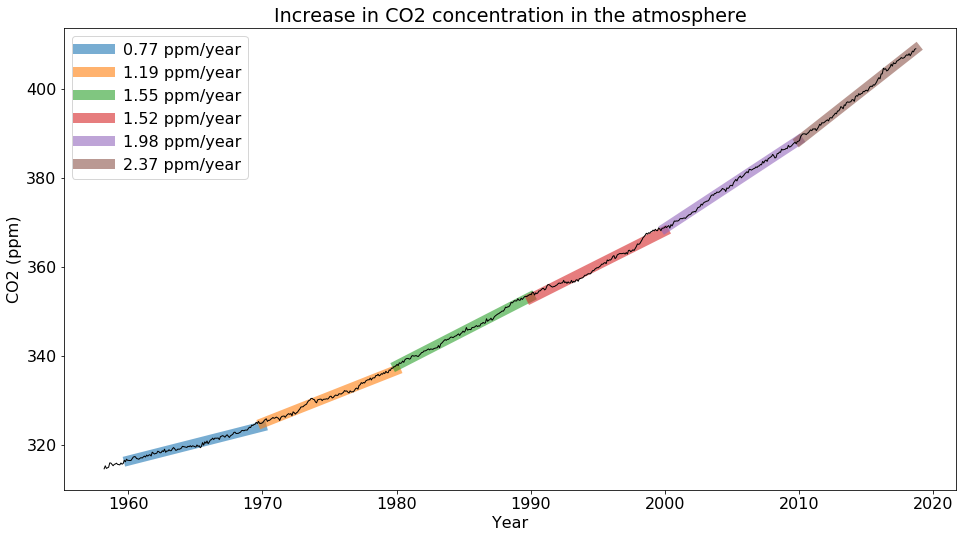

In [9]:
import scipy.optimize
import bisect

fig,ax=plt.subplots(1,figsize=[16,8.5])

def Linear_fit(x,a,b):
    return a*x+b

for i in range(1960,2020,10):
    a=bisect.bisect_left(Date,i)
    b=bisect.bisect_left(Date,i+10)
    
    popt,pcov=scipy.optimize.curve_fit(Linear_fit, Date[a:b], Interpolated[a:b])
    ax.plot(Date[a:b], popt[0]*Date[a:b]+popt[1],linewidth=10,alpha=0.6, label=str(round(popt[0],2))+" ppm/year")
ax.legend()

ax.plot(Date, Trend,alpha=1, linewidth=1,color='black')
ax.set_ylabel("CO2 (ppm)")
ax.set_xlabel("Year")
ax.set_title("Increase in CO2 concentration in the atmosphere")

The acceleration of ppm level is increasing over the year

### Analysis: Seasonal

In a typical time series, I am required to perform various tasks, one of them being investigating the frequency's behavior over time. However the time series we are dealing with is year and we have a reason to speculate that the frequency of the oscillations is invariant over time with its associated wavelength being 1 Year. Let's visualize:

(1958.2079999999999, 2018.7079999999999)

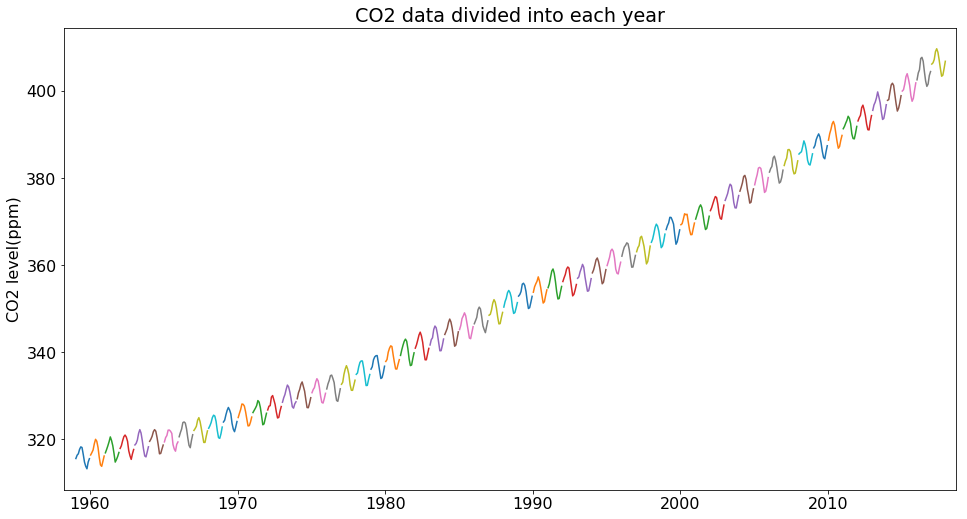

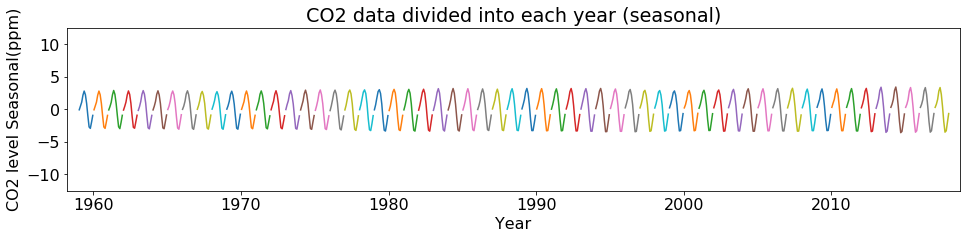

In [10]:
# Getmonths of each data
Date_long_month=np.array([i.split('-')[1] for i in Date_long])
Date_long_Jan=np.where(Date_long_month=='01')[0]
Date_long_Dec=np.where(Date_long_month=='12')[0]

fig,ax0=plt.subplots(1, figsize=[16,8.5])
fig,ax1=plt.subplots(1, figsize=[16,3])

Seasonal= Interpolated-Trend
for e,(i,j) in enumerate(zip(Date_long_Jan, Date_long_Dec[1:])):
    # top plot
    ax0.plot(Date[i:j+1],Interpolated[i:j+1])
    ax1.plot(Date[i:j+1],Seasonal[i:j+1])
    
ax0.set_title("CO2 data divided into each year")
ax1.set_title("CO2 data divided into each year (seasonal)")
ax1.set_ylabel("CO2 level Seasonal(ppm)")
ax0.set_ylabel("CO2 level(ppm)")
ax1.set_xlabel("Year")
ax1.set_ylim(-12.5,12.5)
ax0.set_xlim(Date.iloc[0],Date.iloc[-1])
ax1.set_xlim(Date.iloc[0],Date.iloc[-1])

#plt.show()


As suspected, the frequency of the wave is invariant, and its frequency is 1 year. Now instead of visualizing it as a time series, we compare the similarity between each waves independent of the year.

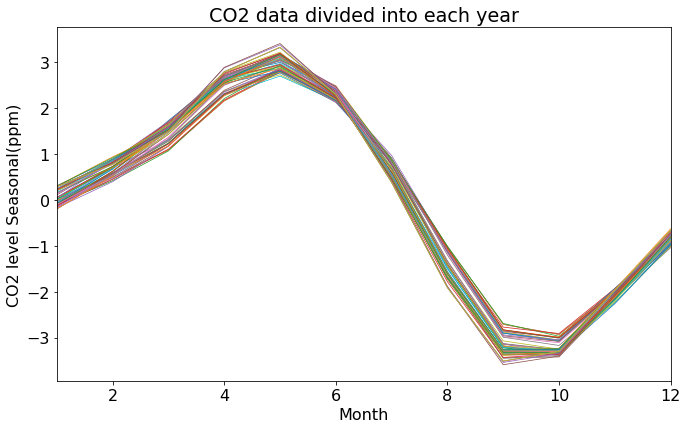

In [11]:
fig,ax=plt.subplots(1, figsize=[11,6.5])

Seasonal= Interpolated-Trend
for e,(i,j) in enumerate(zip(Date_long_Jan, Date_long_Dec[1:])):
    # top plot
    ax.plot(np.arange(1,13),Seasonal[i:j+1],linewidth=0.75)
    
ax.set_title("CO2 data divided into each year")
ax.set_ylabel("CO2 level Seasonal(ppm)")
ax.set_xlabel("Month")
ax.set_xlim([1,12])
plt.show()

While this shows the similarity between each year's CO2 behavior, it's better to employ statistical measures

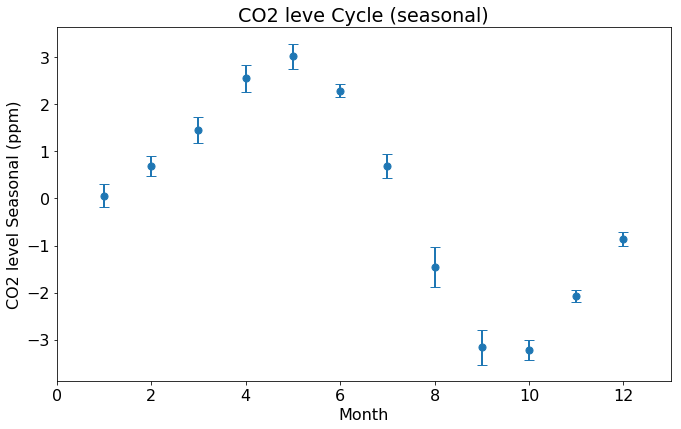

In [12]:
fig,ax=plt.subplots(1, figsize=[11,6.5],sharey=True, sharex=True)

Seasonal= Interpolated-Trend
for i in range(1,13):
    string_month=str(i)
    if len(string_month)<2:
        string_month="0"+string_month
    msk=Date_long_month==str(string_month)
    
    mean=np.mean(Seasonal[msk])
    std=np.std(Seasonal[msk])
    #median=np.median(Seasonal[msk])
    #q25,q75=np.percentile(Seasonal[msk],[25,75])
    #iqr=q75-q25
    
    ax.errorbar(i,mean,yerr=std*1.5,elinewidth=2, barsabove=True,capsize=5,color='C0',zorder=1)
    ax.scatter(i,mean,s=50,color='C0',zorder=2)
    
ax.set_title("CO2 leve Cycle (seasonal)")
ax.set_ylabel("CO2 level Seasonal (ppm)")
ax.set_xlabel("Month")
ax.set_xlim([0,13])
plt.show()

Each point represents the mean CO2 level of each month while the error bars represent 1.5 standard deviations. Higher standard deviations is observed in the months August and September, accompanied by the high gradient of CO2 level vs Month. This confirms that in the entire data set, the seasonal behavior is cyclic with a wavelength of 1 year. The wavelength is invariant over time.

## Prediction

Using regression, I will fit a function $f(x) ,x\in \mathbb{R}$ that will allow me to predict the CO2 level in the future.

No free Lunch theorem (two optimization algorithms are equivalent when their performance is averaged across all possible problems) reminds us that one must carefully examine the problem at hand before applying regression algorithms. So far we've discovered that the trend is non linear and that there is a static (frequency invariant) oscillatory component.


## Curve Fit
### Linear Fit


In [13]:
def chi_square(O,E):
    """Computes chi square
    args:
        O(ndarray) : observed
        E(ndarray) : Expected"""
    return np.sum((O-E)/E)

def poly(x,coeff):
    """Computes a polynomial of the form p0 + p1*x + p2*x^2 + ... upto n degree polynomial where [p0,p1, ...] are provided
    args:
        x(ndarray): input values
        coeff(ndarray or a list): polynomial coefficients)"""
    y=np.ones(x.shape)*coeff[-1]
    for e,p in enumerate(coeff):
        if e!=len(coeff)-1:
            y+=p*x**(len(coeff)-e-1)
    return y

Chi squared:  0.06179516384500916


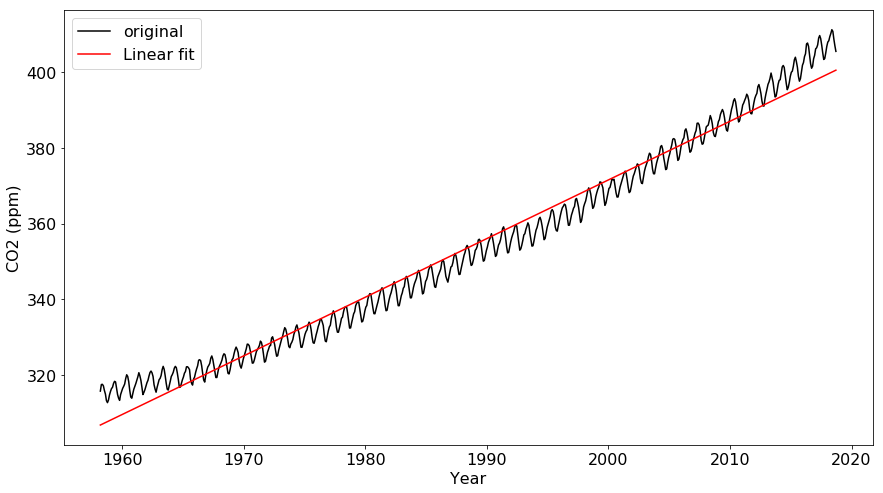

Text(0.5,1,'Predicted vs Observed')

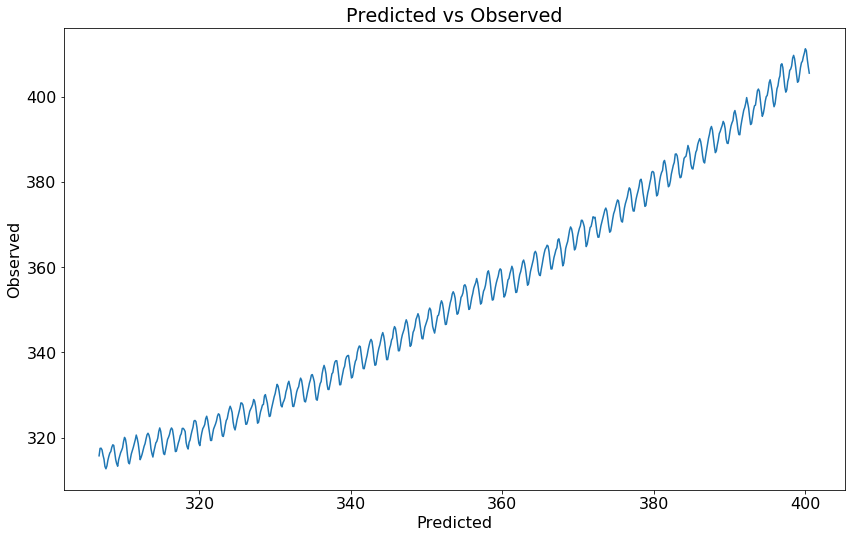

In [14]:
# polynomial fit
x=data['Decimal Date']
y=data['Interpolated']
coeff=np.polyfit(x, y ,1)
yfit=poly(x,coeff)

# plot

plt.figure(figsize=(14.5,8))
plt.plot(x, y, color='black', label='original')
plt.plot(x, yfit, color='red', label='Linear fit')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.legend()
print('Chi squared: ',chi_square(poly(x,coeff),y))
plt.show()

plt.figure(figsize=[14,8.5])
plt.plot(yfit,y)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Predicted vs Observed")

### Polynomial Fit

Chi squared:  0.027175004486711188


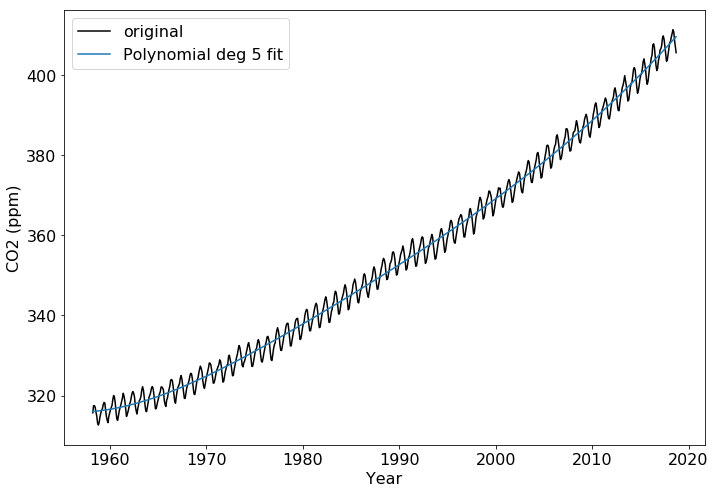

Text(0.5,1,'Predicted vs Observed')

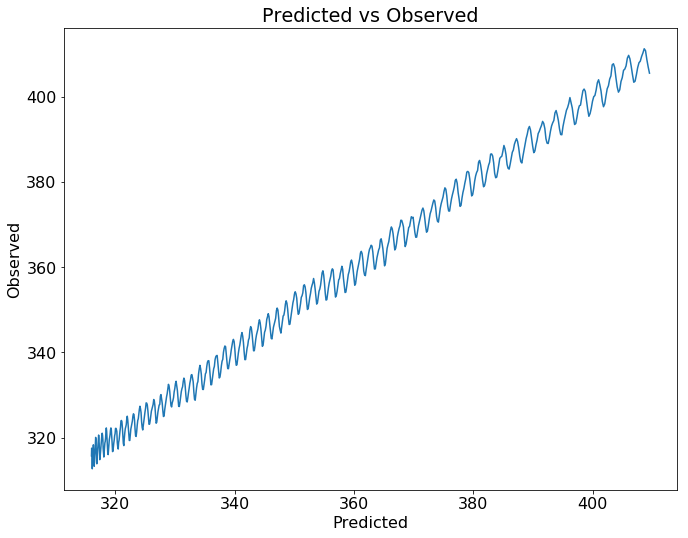

In [15]:
x=data['Decimal Date']
y=data['Interpolated']
coeff=np.polyfit(x,y,5)
yfit=poly(x,coeff)

plt.figure(figsize=[11.5,8])
plt.plot(x, y, color='black', label='original')
plt.plot(x, yfit, color='C0', label='Polynomial deg 5 fit')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.legend()
print('Chi squared: ',chi_square(poly(x,coeff),y))
plt.show()

plt.figure(figsize=[11,8.5])
plt.plot(yfit,y)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Predicted vs Observed")

Polynomial fit improved the chi square by 2-fold. Both visually and statistically, it gives better performance than linear regression.

## Capturing Seasonality:

Both Linear fit and polynomial fit only captures the trend component of the data. The seasonality is yet to be captured. One practical way to fit the seasonality is through Fourier series. The Fourier series is defined as:

$F(x)=a_0 + \sum_{i=1}^{n} a_i cos(\frac{2\pi x}{T}) + b_i sin(\frac{2\pi x}{T})$

## Fourier Series
To use scipy.optimize.curve_fit, the function must be structured such that its arguments can be passed to the curve_fit function
directly. This causes a bit of a problem when it comes to synthesizing fourier series because it is heavily iterative. Therefore I solve this problem by printing out the code and then copy and pasting it as a code.

In [16]:
def fourier_series_synthesizer(n,T):
    print_coeff=""
    print_string=""
    for i in range(1,n):
        print_coeff+=", a_"+str(i)+", b_"+str(i)
        print_string+=" a_"+str(i)+"*np.cos(np.pi*"+ str(i/T) +"*x) +" + " b_"+str(i)+"*np.sin(np.pi*"+str(i/T)+"*x) +"
    
    print("a_0"+print_coeff)
    print(" ")
    print("a_0 +"+print_string)
    
fourier_series_synthesizer(20,4)

a_0, a_1, b_1, a_2, b_2, a_3, b_3, a_4, b_4, a_5, b_5, a_6, b_6, a_7, b_7, a_8, b_8, a_9, b_9, a_10, b_10, a_11, b_11, a_12, b_12, a_13, b_13, a_14, b_14, a_15, b_15, a_16, b_16, a_17, b_17, a_18, b_18, a_19, b_19
 
a_0 + a_1*np.cos(np.pi*0.25*x) + b_1*np.sin(np.pi*0.25*x) + a_2*np.cos(np.pi*0.5*x) + b_2*np.sin(np.pi*0.5*x) + a_3*np.cos(np.pi*0.75*x) + b_3*np.sin(np.pi*0.75*x) + a_4*np.cos(np.pi*1.0*x) + b_4*np.sin(np.pi*1.0*x) + a_5*np.cos(np.pi*1.25*x) + b_5*np.sin(np.pi*1.25*x) + a_6*np.cos(np.pi*1.5*x) + b_6*np.sin(np.pi*1.5*x) + a_7*np.cos(np.pi*1.75*x) + b_7*np.sin(np.pi*1.75*x) + a_8*np.cos(np.pi*2.0*x) + b_8*np.sin(np.pi*2.0*x) + a_9*np.cos(np.pi*2.25*x) + b_9*np.sin(np.pi*2.25*x) + a_10*np.cos(np.pi*2.5*x) + b_10*np.sin(np.pi*2.5*x) + a_11*np.cos(np.pi*2.75*x) + b_11*np.sin(np.pi*2.75*x) + a_12*np.cos(np.pi*3.0*x) + b_12*np.sin(np.pi*3.0*x) + a_13*np.cos(np.pi*3.25*x) + b_13*np.sin(np.pi*3.25*x) + a_14*np.cos(np.pi*3.5*x) + b_14*np.sin(np.pi*3.5*x) + a_15*np.cos(np.pi*3.75*x) 

In [17]:
def fourier_series(x, a_0, a_1, b_1, a_2, b_2, a_3, b_3, a_4, b_4, a_5, b_5, a_6, b_6, a_7, b_7, a_8, b_8, a_9, b_9, a_10, b_10, a_11, b_11, a_12, b_12, a_13, b_13, a_14, b_14, a_15, b_15, a_16, b_16, a_17, b_17, a_18, b_18, a_19, b_19):
    
    return a_0 + a_1*np.cos(np.pi*0.25*x) + b_1*np.sin(np.pi*0.25*x) + a_2*np.cos(np.pi*0.5*x) + b_2*np.sin(np.pi*0.5*x) + a_3*np.cos(np.pi*0.75*x) + b_3*np.sin(np.pi*0.75*x) + a_4*np.cos(np.pi*1.0*x) + b_4*np.sin(np.pi*1.0*x) + a_5*np.cos(np.pi*1.25*x) + b_5*np.sin(np.pi*1.25*x) + a_6*np.cos(np.pi*1.5*x) + b_6*np.sin(np.pi*1.5*x) + a_7*np.cos(np.pi*1.75*x) + b_7*np.sin(np.pi*1.75*x) + a_8*np.cos(np.pi*2.0*x) + b_8*np.sin(np.pi*2.0*x) + a_9*np.cos(np.pi*2.25*x) + b_9*np.sin(np.pi*2.25*x) + a_10*np.cos(np.pi*2.5*x) + b_10*np.sin(np.pi*2.5*x) + a_11*np.cos(np.pi*2.75*x) + b_11*np.sin(np.pi*2.75*x) + a_12*np.cos(np.pi*3.0*x) + b_12*np.sin(np.pi*3.0*x) + a_13*np.cos(np.pi*3.25*x) + b_13*np.sin(np.pi*3.25*x) + a_14*np.cos(np.pi*3.5*x) + b_14*np.sin(np.pi*3.5*x) + a_15*np.cos(np.pi*3.75*x) + b_15*np.sin(np.pi*3.75*x) + a_16*np.cos(np.pi*4.0*x) + b_16*np.sin(np.pi*4.0*x) + a_17*np.cos(np.pi*4.25*x) + b_17*np.sin(np.pi*4.25*x) + a_18*np.cos(np.pi*4.5*x) + b_18*np.sin(np.pi*4.5*x) + a_19*np.cos(np.pi*4.75*x) + b_19*np.sin(np.pi*4.75*x)

Now curve_fit function can be used

In [18]:
import scipy.optimize

x=data['Decimal Date']
y=data['Interpolated']

popt,pcov=scipy.optimize.curve_fit(fourier_series, x, y)
popt

array([ 3.53599250e+02,  3.33696377e-01,  9.34776454e-01, -1.32168633e+00,
        1.20775364e+00,  6.58145078e-01, -5.53561687e-01,  6.31944389e-01,
        8.72089159e-02, -7.15722457e-01, -1.02759849e-01, -2.32634410e-04,
       -1.68218166e-01,  3.21384428e-01,  4.77776248e-01, -1.12888191e+00,
        2.52634858e+00,  7.92380107e-02, -3.67535691e-01, -7.51473008e-02,
        2.65139825e-01, -1.78754396e-01,  8.29516891e-02,  2.88533224e-01,
       -1.23860694e-01,  5.27088649e-02,  2.52605165e-02, -2.57120763e-01,
       -1.00939966e-01,  1.05274910e-01, -1.52406812e-03,  7.48153338e-01,
       -2.27033213e-01, -5.23961065e-02, -1.84921300e-01,  7.04318011e-02,
       -1.25034500e-01, -9.30283916e-02,  1.99810691e-01])

(1980, 2000)

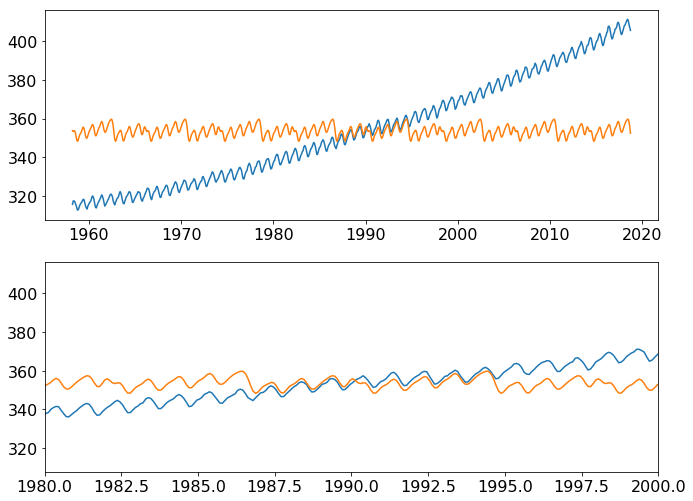

In [19]:
fig,ax=plt.subplots(2,figsize=[11,8.5])
ax[0].plot(x,y)
ax[0].plot(x, fourier_series(x,*popt))
ax[1].plot(x,y)
ax[1].plot(x, fourier_series(x,*popt))
ax[1].set_xlim([1980,2000])



This time we have captured the seasonality, however it did not capture the trend. 

fourier plus linear

## Polynomial fit + fourier series fit

So the polynomial fit cannot capture the seasonality, and the fourier series cannot capture the trend (In theory it can, but it is not always practical). The obvious solution here is to combine the two:

In [20]:
def fourier_series(x, p1 , p2 , p3 , p4 , p5 , a_0, a_1, b_1, a_2, b_2, a_3, b_3, a_4, b_4, a_5, b_5, a_6, b_6, a_7, b_7, a_8, b_8, a_9, b_9, a_10, b_10, a_11, b_11, a_12, b_12, a_13, b_13, a_14, b_14, a_15, b_15, a_16, b_16, a_17, b_17, a_18, b_18, a_19, b_19):
    
    return p1*x + p2*x**2 + p3*x**3 + p4*x**4 + p5*x**5 + a_0 + a_1*np.cos(np.pi*0.25*x) + b_1*np.sin(np.pi*0.25*x) + a_2*np.cos(np.pi*0.5*x) + b_2*np.sin(np.pi*0.5*x) + a_3*np.cos(np.pi*0.75*x) + b_3*np.sin(np.pi*0.75*x) + a_4*np.cos(np.pi*1.0*x) + b_4*np.sin(np.pi*1.0*x) + a_5*np.cos(np.pi*1.25*x) + b_5*np.sin(np.pi*1.25*x) + a_6*np.cos(np.pi*1.5*x) + b_6*np.sin(np.pi*1.5*x) + a_7*np.cos(np.pi*1.75*x) + b_7*np.sin(np.pi*1.75*x) + a_8*np.cos(np.pi*2.0*x) + b_8*np.sin(np.pi*2.0*x) + a_9*np.cos(np.pi*2.25*x) + b_9*np.sin(np.pi*2.25*x) + a_10*np.cos(np.pi*2.5*x) + b_10*np.sin(np.pi*2.5*x) + a_11*np.cos(np.pi*2.75*x) + b_11*np.sin(np.pi*2.75*x) + a_12*np.cos(np.pi*3.0*x) + b_12*np.sin(np.pi*3.0*x) + a_13*np.cos(np.pi*3.25*x) + b_13*np.sin(np.pi*3.25*x) + a_14*np.cos(np.pi*3.5*x) + b_14*np.sin(np.pi*3.5*x) + a_15*np.cos(np.pi*3.75*x) + b_15*np.sin(np.pi*3.75*x) + a_16*np.cos(np.pi*4.0*x) + b_16*np.sin(np.pi*4.0*x) + a_17*np.cos(np.pi*4.25*x) + b_17*np.sin(np.pi*4.25*x) + a_18*np.cos(np.pi*4.5*x) + b_18*np.sin(np.pi*4.5*x) + a_19*np.cos(np.pi*4.75*x) + b_19*np.sin(np.pi*4.75*x)

In [21]:
import scipy.optimize

x=data['Decimal Date']
y=data['Interpolated']

popt,pcov=scipy.optimize.curve_fit(fourier_series, x, y)
popt

array([ 1.50167985e-01, -2.63798336e+01,  2.65377288e-02, -1.00123010e-05,
        1.34327337e-09,  1.04296406e+07,  2.65212910e-02, -1.53593605e-01,
       -1.36090964e-02, -6.19648534e-03, -3.68254905e-03,  8.16281462e-04,
        1.88975100e-02,  1.92498766e-02,  6.06415468e-03,  9.67416908e-03,
        3.54840118e-02, -1.83248673e-03, -5.52589616e-03,  9.71510526e-03,
       -1.00908942e+00,  2.63627478e+00,  5.81613294e-05,  1.69842610e-02,
       -2.70915890e-03, -2.56329602e-03,  1.11670401e-02, -1.82441997e-02,
        4.15532127e-03,  1.69497520e-02,  8.94656640e-03, -2.93654964e-02,
        1.77543783e-02, -2.00465145e-03,  6.47050193e-03, -2.22631854e-02,
        6.60495078e-01, -4.29159831e-01,  6.55167917e-03, -1.54287436e-02,
        1.19626770e-02, -1.58500072e-02,  1.11057865e-02,  1.26107517e-02])

Chi square:  0.00018076967841009622


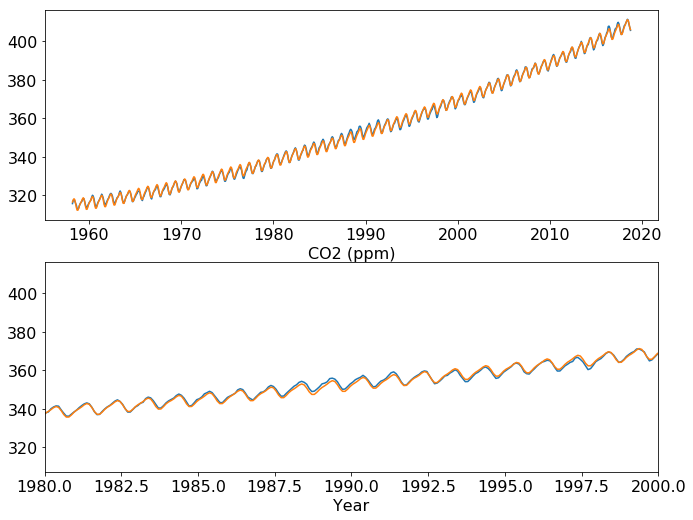

In [22]:
fig,ax=plt.subplots(2,figsize=[11,8.5])
ax[0].plot(x,y,label='original')
ax[0].plot(x, fourier_series(x,*popt),label='Hybrid fit')
ax[0].set_xlabel("CO2 (ppm)")
ax[1].plot(x,y,label='original')
ax[1].plot(x, fourier_series(x,*popt),label='Hybrid fit')
ax[0].set_xlabel("CO2 (ppm)")
ax[1].set_xlim([1980,2000])
ax[1].set_xlabel("Year")

print("Chi square: ",chi_square(y,fourier_series(x,*popt)))

## Prediction

I have the fitted function, validated by the chi square test. Let's see what the CO2 level would be like in the future

(0, 8931.371769184534)

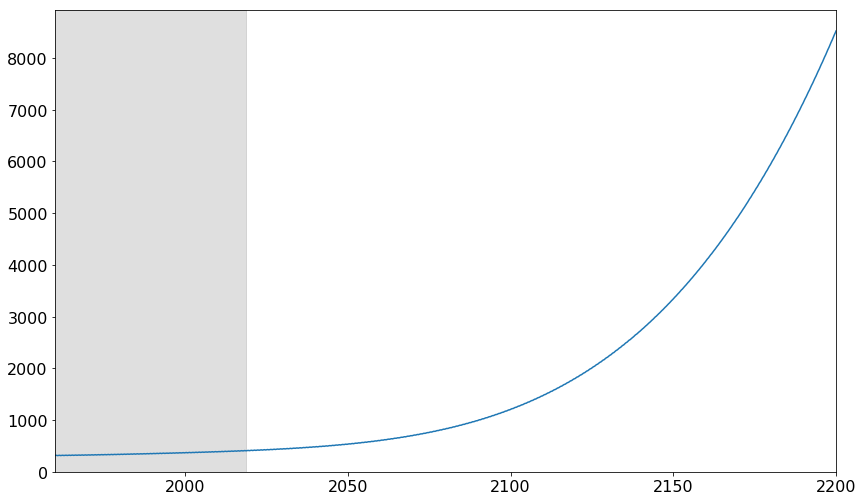

In [23]:
fig,ax=plt.subplots(1, figsize=[14,8.5])
ax.plot(np.linspace(1960,2200,12*260), fourier_series(np.linspace(1960,2200,12*260),*popt))

ax.axvspan(  data['Decimal Date'].iloc[0], data['Decimal Date'].iloc[-1]  ,color='gray',alpha=0.25)
ax.set_xlim(1960,2200)
ax.set_ylim(bottom=0)

In general one shouldn't use polynomial for extrapolation because they tend to 'explode' outside the domain that was used for fitting. This is where deep learning might come in handy

### Deep Learning Approach

In [24]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import warnings 
#warnings.filterwarnings('ignore')
#warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

C:\Users\David\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "C:\Users\David\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\David\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\David\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\David\Anaconda3\lib\imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\David\Anaconda3\lib\imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
wednesday 6  -  